In [1]:
import numpy as np
a = 3
N = 4

# x 0 1 2 3 4 5 6 7 8
#
#   0 0 0 1 1 1 2 2 2
#   0 1 2 0 1 2 0 1 2
#                 |
#                 |


x = 7
bin_x = '0111'

In [2]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [3]:
def all_config(size):
    all_pat = []
    for i in range(size-1):
        for v1 in range(2):
            for v2 in range(2):
                all_pat.append( [i] + bin_to_pattern(str(v1)+str(v2)) + [size-i-2])
    return all_pat

In [4]:
def overlapp(x,measurement):
    i = measurement[0]
    return int(measurement[1]==x[i] and measurement[2]==x[i+1])

In [5]:
def short_to_full(measurement):
    return [[1,1]]*measurement[0] + [measurement[1]] + [measurement[2]] + [[1,1]]*measurement[3]

In [6]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

In [7]:
def decomposition(mat):
    a,b,c,d = mat[0],mat[1],mat[2],mat[3]
    return 1/4 * np.array( [a+b+c+d, a+b-c-d, a-b+c-d, a-b-c+d] )

In [8]:
pat = bin_to_pattern(bin_x)
all_pat = all_config(4)

y = np.matrix([ overlapp(pat,p) for p in all_pat]).T

A = np.matrix([ dev_pattern(short_to_full(p)) for p in all_pat])

print(A.T*y)

[[0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [2]
 [3]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [2]]


In [18]:
# I, s1, s2, s3, s4, s1s2, s2s3, s3s4

H = [0]*8

for p,yi in zip(all_pat,y):
    if p[0] == 0:
        # I, s1, s2, s1s2
        coef = decomposition(dev_pattern([p[1],p[2]]))*yi[0,0]
        H[0:3]+=coef[0:3]
        H[5]+= coef[3]
    elif p[0] == 1:
        # I, s2, s3, s2s3
        coef = decomposition(dev_pattern([p[1],p[2]]))*yi[0,0]
        H[0]+=coef[0]
        H[2:4]+= coef[1:3]
        H[6]+= coef[3]
    else:
        # I, s3, s4, s3s4
        coef = decomposition(dev_pattern([p[1],p[2]]))*yi[0,0]
        H[0]+=coef[0]
        H[3:5]+=coef[1:3]
        H[7]+= coef[3]
    print(coef)
    print(yi[0,0])
print(H)

[0. 0. 0. 0.]
0
[ 0.25  0.25 -0.25 -0.25]
1
[ 0. -0.  0. -0.]
0
[ 0. -0. -0.  0.]
0
[0. 0. 0. 0.]
0
[ 0.  0. -0. -0.]
0
[ 0. -0.  0. -0.]
0
[ 0.25 -0.25 -0.25  0.25]
1
[0. 0. 0. 0.]
0
[ 0.  0. -0. -0.]
0
[ 0. -0.  0. -0.]
0
[ 0.25 -0.25 -0.25  0.25]
1
[0.75, 0.25, -0.5, -0.5, -0.25, -0.25, 0.25, 0.25]


In [90]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

In [91]:
nqubits = 4

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
qc_p.rz(2*gamma*H[1],0)
qc_p.rz(2*gamma*H[2],1)
qc_p.rz(2*gamma*H[3],2)
qc_p.rz(2*gamma*H[4],3)
qc_p.rzz(2*gamma*H[5],0,1)
qc_p.rzz(2*gamma*H[6],1,2)
qc_p.rzz(2*gamma*H[7],2,3) 
    
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

global phase: 1.0*$\gamma$
     ┌─────────┐┌────────────────┐ ┌──────────────────┐     »
q_0: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─┤ U1(0.5*$\gamma$) ├──■──»
     ├─────────┤├────────────────┤┌┴──────────────────┤┌─┴─┐»
q_1: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├┤ U1(-1.0*$\gamma$) ├┤ X ├»
     ├─────────┤├────────────────┤├───────────────────┤└───┘»
q_2: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├┤ U1(-1.0*$\gamma$) ├─────»
     ├─────────┤├────────────────┤├───────────────────┤     »
q_3: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├┤ U1(-0.5*$\gamma$) ├─────»
     └─────────┘└────────────────┘└───────────────────┘     »
«                                                                  »
«q_0: ───────────────────────■─────────────────────────────────────»
«     ┌───────────────────┐┌─┴─┐                                   »
«q_1: ┤ Rz(-0.5*$\gamma$) ├┤ X ├──■────────────────────────■───────»
«     └───────────────────┘└───┘┌─┴─┐┌──────────────────┐┌─┴─┐     »
«q_2: ──────────────────────────┤ X ├┤ Rz(0.5*$\gamma$) ├┤ X ├──■──»
«                               └───┘└──────────────────┘└───┘┌─┴─┐»
«q_3: ────────────────────────────────────────────────────────┤ X ├»
«                                                             └───┘»
«                              
«q_0: ─────────────────────────
«                              
«q_1: ─────────────────────────
«                              
«q_2: ──────────────────────■──
«     ┌──────────────────┐┌─┴─┐
«q_3: ┤ Rz(0.5*$\gamma$) ├┤ X ├
«     └──────────────────┘└───┘

In [92]:
from bitstring import BitArray

def obj_func(z):
    v = BitArray(bin='0'+z).int
    return (A.T[v] * y)[0,0]


def compute_expectation(counts):
        
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = -obj_func(bitstring)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(theta):

    nqubits = 4
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

        qc.rz(2*gamma[irep]*H[1],0)
        qc.rz(2*gamma[irep]*H[2],1)
        qc.rz(2*gamma[irep]*H[3],2)
        qc.rz(2*gamma[irep]*H[4],3)
        qc.rzz(2*gamma[irep]*H[5],0,1)
        qc.rzz(2*gamma[irep]*H[6],1,2)
        qc.rzz(2*gamma[irep]*H[7],2,3) 

    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

In [95]:
from scipy.optimize import minimize


expectation = get_expectation()

res = minimize(expectation, 
                      np.ones(10), 
                      method='COBYLA')
res

     fun: -2.5400390625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 108
  status: 1
 success: True
       x: array([0.93081486, 0.92297288, 0.76273696, 0.55723079, 0.95751686,
       0.76198897, 2.1931466 , 1.24733079, 1.38256256, 0.89332536])

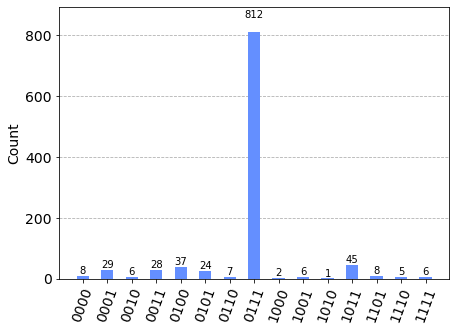

In [96]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)